In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from sklearn.model_selection import train_test_split

# Hyperparamètres

In [123]:
# --- General ---
n_points_per_dim = 100  # Grid resolution for point generation
n_plot = 50  # Grid resolution for evaluation and plotting
pi = np.pi

# --- Physics (Source Term) ---
a = 1.5
b = 0.5

# --- PINN Training ---
pinn_lr = 1e-3
pinn_epochs = 1_000

# --- Supervised Training ---
sup_lr = 1e-3
sup_epochs = 1_000
sup_batch_size = 128

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Partie 1: Entrainement PINN non supervisé

## 1. Génération des points : intérieurs et bord

In [124]:
# Define grid resolution (using hyperparameter)
n_interior_total = (n_points_per_dim - 2) ** 2
n_boundary_total = 4 * (n_points_per_dim - 1)

# Generate grid points
x_lin = np.linspace(0, 1, n_points_per_dim)
y_lin = np.linspace(0, 1, n_points_per_dim)
X_grid, Y_grid = np.meshgrid(x_lin, y_lin)
XY_grid = np.stack([X_grid.flatten(), Y_grid.flatten()], axis=-1)

# Separate interior and boundary points
is_boundary = (
    (XY_grid[:, 0] == 0.0)
    | (XY_grid[:, 0] == 1.0)
    | (XY_grid[:, 1] == 0.0)
    | (XY_grid[:, 1] == 1.0)
)
X_interior = XY_grid[~is_boundary]
X_boundary = XY_grid[is_boundary]

# Ensure the counts match (adjust n_points_per_dim if needed)
n_interior = X_interior.shape[0]
n_boundary = X_boundary.shape[0]
print(f"Generated {n_interior} interior points and {n_boundary} boundary points.")

# Convert to tensors and move to device
x_interior = torch.tensor(X_interior, dtype=torch.float32, requires_grad=True).to(
    device
)
x_boundary = torch.tensor(X_boundary, dtype=torch.float32).to(device)
u_boundary = torch.zeros((n_boundary, 1), dtype=torch.float32).to(device)

Generated 9604 interior points and 396 boundary points.


## 2. La fonction source
$ f(x,y) = x \sin(a\pi y) + y\sin(b\pi x) $

In [125]:
def source(x):
    # Ensure x is a tensor for source calculation if needed elsewhere
    if isinstance(x, np.ndarray):
        x_tensor = torch.tensor(x, dtype=torch.float32)
    else:
        x_tensor = x
    f_val = x_tensor[:, 1:2] * torch.sin(a * pi * x_tensor[:, 0:1]) + x_tensor[
        :, 0:1
    ] * torch.sin(b * pi * x_tensor[:, 1:2])
    # Return numpy if input was numpy, for FD solver
    if isinstance(x, np.ndarray):
        return f_val.numpy()
    else:
        return f_val

## 3. Réseau de neurones (PINN)

In [126]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)


model = PINN().to(device)

## 4. Calcul du résidu de l'équation de Poisson (∆u + f(x, y) = 0)

In [127]:
def poisson_residual(x):
    u = model(x)

    grad_u = torch.autograd.grad(
        u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True
    )[0]

    u_x = grad_u[:, 0:1]

    u_y = grad_u[:, 1:2]

    u_xx = torch.autograd.grad(
        u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True
    )[0][:, 0:1]

    u_yy = torch.autograd.grad(
        u_y, x, grad_outputs=torch.ones_like(u_y), retain_graph=True, create_graph=True
    )[0][:, 1:2]

    laplacian = u_xx + u_yy
    return laplacian + source(x)

## 5. Fonction de coût combinant erreur du résidu et condition frontière

In [128]:
def loss_function():
    res = poisson_residual(x_interior)
    loss_interior = torch.mean(res**2)
    u_pred_boundary = model(x_boundary)
    loss_boundary = torch.mean((u_pred_boundary - u_boundary) ** 2)
    return loss_interior + 1000 * loss_boundary

## 6. Optimisation avec Adam

In [129]:
optimizer = optim.Adam(model.parameters(), lr=pinn_lr)

## 7. Entraînement

In [130]:
for epoch in range(pinn_epochs):
    optimizer.zero_grad()
    loss = loss_function()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.6f}")


Epoch 0 - Loss: 10.722277


Epoch 500 - Loss: 0.105152


## 8. Évaluation sur une grille 2D

In [131]:
x = np.linspace(0, 1, n_plot)
y = np.linspace(0, 1, n_plot)
X, Y = np.meshgrid(x, y)
xy = np.stack([X.flatten(), Y.flatten()], axis=-1)
xy_tensor = torch.tensor(xy, dtype=torch.float32).to(device)  # Move to device

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    u_pred = model(xy_tensor).cpu().numpy().reshape(n_plot, n_plot)

## 9. Visualisation de la solution

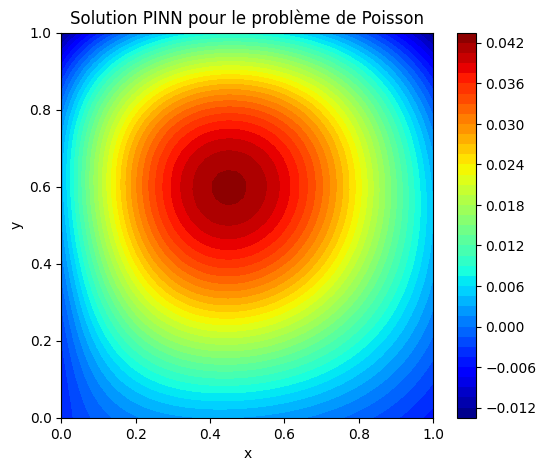

In [132]:
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, u_pred, levels=50, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution PINN pour le problème de Poisson")
plt.show()

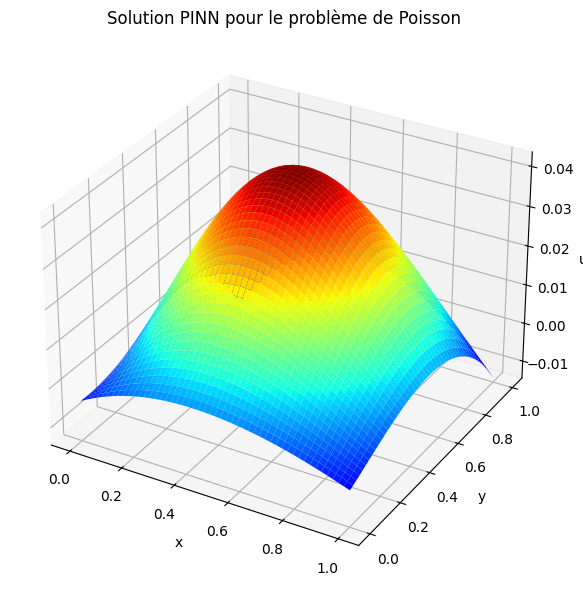

In [133]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, u_pred, cmap="jet")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u")

ax.set_title("Solution PINN pour le problème de Poisson")
plt.tight_layout()
plt.show()

## 10. Solution par Différences Finies (Référence Numérique)

In [134]:
def solve_poisson_fd(nx, ny, a, b):
    """Solve Poisson eq using Finite Differences on [0,1]x[0,1] with u=0 BC."""
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    dx2 = dx**2
    dy2 = dy**2

    # Grid for source term evaluation
    X, Y = np.meshgrid(x, y)
    xy_grid = np.stack([X.flatten(), Y.flatten()], axis=-1)

    # Evaluate source term f on the grid
    f_grid = source(xy_grid).reshape(ny, nx)

    # Number of interior points
    nx_int = nx - 2
    ny_int = ny - 2
    N = nx_int * ny_int

    # Assemble the matrix A (discrete Laplacian)
    main_diag = np.ones(N) * (-2 / dx2 - 2 / dy2)
    off_diag_x = np.ones(N - 1) / dx2
    off_diag_y = np.ones(N - nx_int) / dy2

    # Adjust off_diag_x for boundaries between rows
    for i in range(1, ny_int):
        off_diag_x[i * nx_int - 1] = 0

    diagonals = [main_diag, off_diag_x, off_diag_x, off_diag_y, off_diag_y]
    offsets = [0, -1, 1, -nx_int, nx_int]
    A = sp.diags(diagonals, offsets, shape=(N, N), format="csr")

    # Assemble the right-hand side vector F
    # We need -f evaluated at interior points
    F = -f_grid[1:-1, 1:-1].flatten()

    # Solve the linear system AU = F
    U_int = spsolve(A, F)

    # Reshape solution and add boundary conditions (u=0)
    u_sol = np.zeros((ny, nx))
    u_sol[1:-1, 1:-1] = U_int.reshape((ny_int, nx_int))

    return x, y, u_sol

In [135]:
# Solve using Finite Differences on the same grid size as PINN evaluation
nx_fd, ny_fd = n_plot, n_plot
x_fd, y_fd, u_fd = solve_poisson_fd(nx_fd, ny_fd, a, b)
X_fd, Y_fd = np.meshgrid(x_fd, y_fd)  # Grid for plotting FD solution

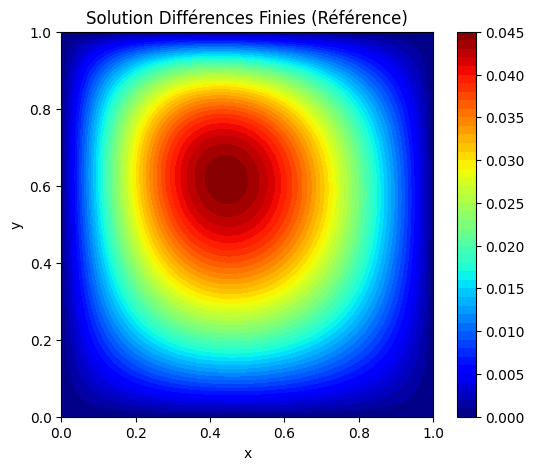

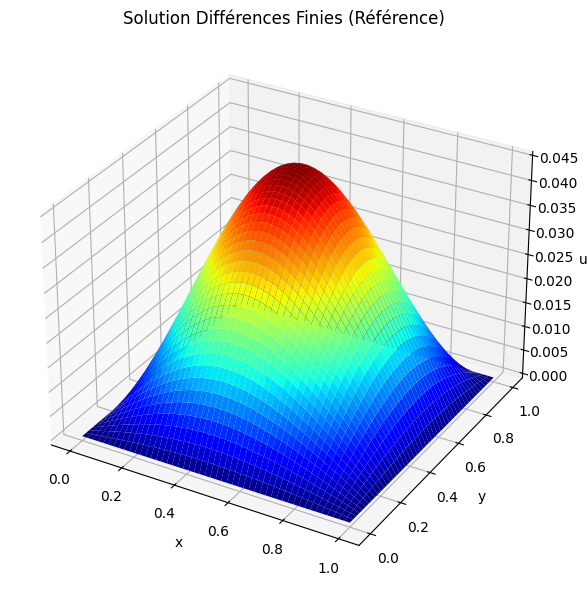

In [136]:
# Visualisation de la solution par Différences Finies
plt.figure(figsize=(6, 5))
plt.contourf(X_fd, Y_fd, u_fd, levels=50, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution Différences Finies (Référence)")
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X_fd, Y_fd, u_fd, cmap="jet")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u")
ax.set_title("Solution Différences Finies (Référence)")
plt.tight_layout()
plt.show()

## 11. Comparaison PINN vs Différences Finies

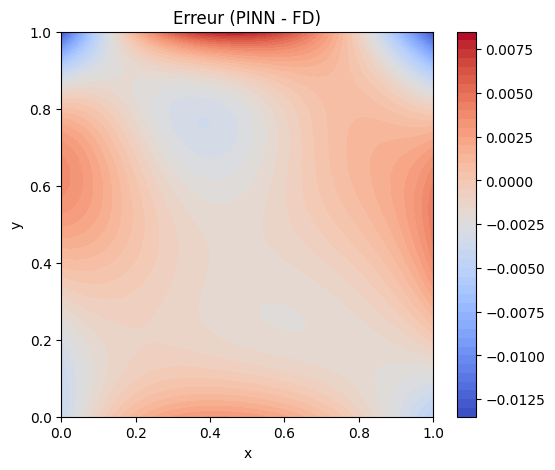

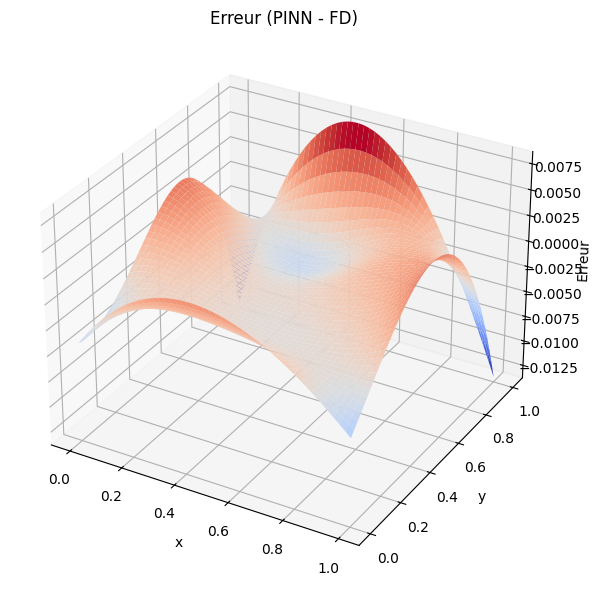

In [137]:
# Calcul de l'erreur PINN vs FD
# Note: u_pred and u_fd are calculated on the same grid (X, Y or X_fd, Y_fd)
error_pinn_fd = u_pred - u_fd

# Visualisation de l'erreur
plt.figure(figsize=(6, 5))
plt.contourf(
    X, Y, error_pinn_fd, levels=50, cmap="coolwarm"
)  # Utiliser une cmap divergente
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Erreur (PINN - FD)")
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, error_pinn_fd, cmap="coolwarm")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("Erreur")
ax.set_title("Erreur (PINN - FD)")
plt.tight_layout()
plt.show()

In [138]:
# Calcul des métriques d'erreur (PINN vs FD)
mse_pinn_fd = np.mean(error_pinn_fd**2)
# Avoid division by zero if FD solution is zero everywhere
norm_u_fd = np.linalg.norm(u_fd)
if norm_u_fd < 1e-10:
    relative_l2_error_pinn_fd = np.linalg.norm(error_pinn_fd)
else:
    relative_l2_error_pinn_fd = np.linalg.norm(error_pinn_fd) / norm_u_fd

print(f"Mean Squared Error (PINN vs FD): {mse_pinn_fd:.6e}")
print(f"Relative L2 Error (PINN vs FD): {relative_l2_error_pinn_fd:.6f}")

Mean Squared Error (PINN vs FD): 4.983990e-06
Relative L2 Error (PINN vs FD): 0.101783


In [139]:
# L'erreur physique est mesurée par le résidu moyen calculé pendant l'entraînement.
# L'erreur par rapport à la solution par différences finies donne une mesure de la précision par rapport à une méthode numérique classique.

# Part 2: Régression supervisée sur solutions numériques (FD)

Dans cette partie, nous allons entraîner un réseau de neurones de manière supervisée en utilisant la solution obtenue par la méthode des différences finies comme données d'entraînement. L'objectif est de voir si un réseau peut apprendre la solution directement à partir des données numériques.

## 2.1 Préparation des données d'entraînement

In [140]:
# Utiliser la grille et la solution FD comme données
# Input: Coordonnées (x, y) de la grille FD
X_fd_flat = np.stack([X_fd.flatten(), Y_fd.flatten()], axis=-1)
# Target: Solution u calculée par FD sur ces points
y_fd_flat = u_fd.flatten()

# Split data: 80% train, 10% validation, 10% test
X_train_np, X_temp_np, y_train_np, y_temp_np = train_test_split(
    X_fd_flat, y_fd_flat, test_size=0.2, random_state=42
)
X_val_np, X_test_np, y_val_np, y_test_np = train_test_split(
    X_temp_np, y_temp_np, test_size=0.5, random_state=42
)

# Convert to tensors and move to device
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1).to(device)
X_val = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val_np, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1).to(device)

print("Data shapes:")
print(f"  Train:      Input: {X_train.shape}, Target: {y_train.shape}")
print(f"  Validation: Input: {X_val.shape}, Target: {y_val.shape}")
print(f"  Test:       Input: {X_test.shape}, Target: {y_test.shape}")

Data shapes:
  Train:      Input: torch.Size([2000, 2]), Target: torch.Size([2000, 1])
  Validation: Input: torch.Size([250, 2]), Target: torch.Size([250, 1])
  Test:       Input: torch.Size([250, 2]), Target: torch.Size([250, 1])


## 2.2 Définition du modèle supervisé

In [141]:
# On peut réutiliser la même architecture que le PINN ou en définir une nouvelle
class SupervisedNet(nn.Module):
    def __init__(self):
        super(SupervisedNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)


model_sup = SupervisedNet().to(device)

## 2.3 Fonction de coût et Optimiseur

In [142]:
criterion_sup = nn.MSELoss()  # Mean Squared Error Loss pour la régression
optimizer_sup = optim.Adam(model_sup.parameters(), lr=sup_lr)

## 2.4 Entraînement du modèle supervisé

In [ ]:
# Use the training split for the DataLoader
# Note: DataLoader loads data to CPU first, move to device in the loop
dataset = torch.utils.data.TensorDataset(
    X_train.cpu(), y_train.cpu()
)  # DataLoader expects CPU tensors
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=sup_batch_size, shuffle=True
)

train_losses = []
val_losses = []

for epoch in range(sup_epochs):
    model_sup.train()  # Set model to training mode
    epoch_train_loss = 0.0
    for batch_x, batch_y in dataloader:
        # Move batch to device
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer_sup.zero_grad()
        outputs = model_sup(batch_x)
        loss = criterion_sup(outputs, batch_y)
        loss.backward()
        optimizer_sup.step()
        epoch_train_loss += loss.item() * batch_x.size(0)

    epoch_train_loss /= len(dataset)
    train_losses.append(epoch_train_loss)

    # Validation step
    model_sup.eval()  # Set model to evaluation mode
    epoch_val_loss = 0.0
    with torch.no_grad():
        # Ensure validation data is on the correct device
        val_outputs = model_sup(X_val)
        val_loss = criterion_sup(val_outputs, y_val)
        epoch_val_loss = val_loss.item()
    val_losses.append(epoch_val_loss)

    if epoch % 100 == 0:  # Print less frequently
        print(
            f"Epoch {epoch} - Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}"
        )

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Supervised Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Epoch 0 - Train Loss: 0.000966, Val Loss: 0.000225


Epoch 100 - Train Loss: 0.000007, Val Loss: 0.000008
Epoch 200 - Train Loss: 0.000003, Val Loss: 0.000002
Epoch 300 - Train Loss: 0.000001, Val Loss: 0.000002
Epoch 400 - Train Loss: 0.000003, Val Loss: 0.000004


KeyboardInterrupt: 

: 

## 2.5 Évaluation et Visualisation (Modèle Supervisé)

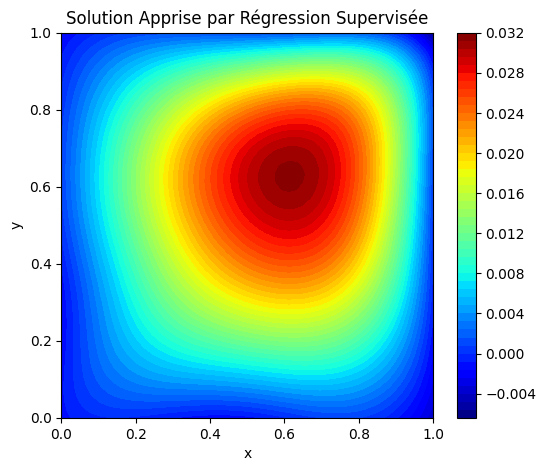

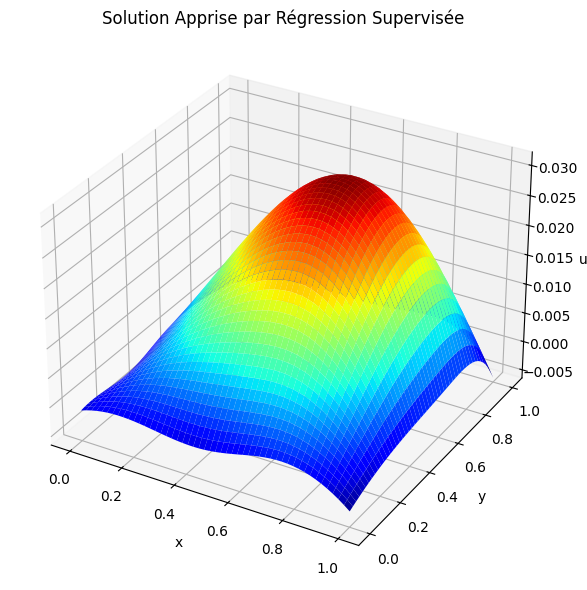

In [ ]:
# Évaluation sur la même grille que précédemment
model_sup.eval()  # Mettre le modèle en mode évaluation
with torch.no_grad():
    # Utiliser xy_tensor qui correspond à la grille d'évaluation (X, Y)
    # Ensure xy_tensor is on the correct device (it should be from PINN eval, but double-check)
    if xy_tensor.device != device:
        xy_tensor = xy_tensor.to(device)
    u_pred_sup = model_sup(xy_tensor).cpu().numpy().reshape(n_plot, n_plot)

# Visualisation de la solution supervisée
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, u_pred_sup, levels=50, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution Apprise par Régression Supervisée")
plt.show()

fig_sup = plt.figure(figsize=(8, 6))
ax_sup = fig_sup.add_subplot(111, projection="3d")
ax_sup.plot_surface(X, Y, u_pred_sup, cmap="jet")
ax_sup.set_xlabel("x")
ax_sup.set_ylabel("y")
ax_sup.set_zlabel("u")
ax_sup.set_title("Solution Apprise par Régression Supervisée")
plt.tight_layout()
plt.show()

## 2.6 Comparaison Supervisé vs Différences Finies

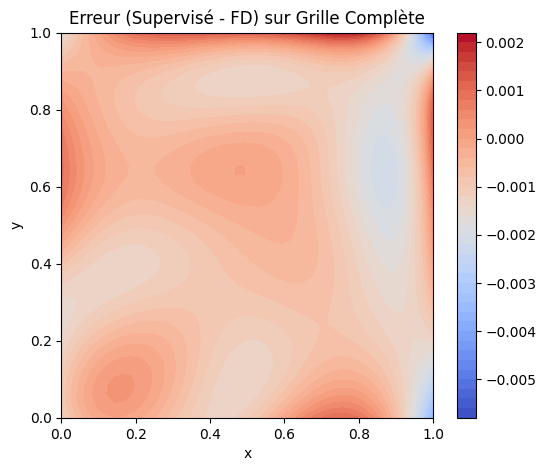

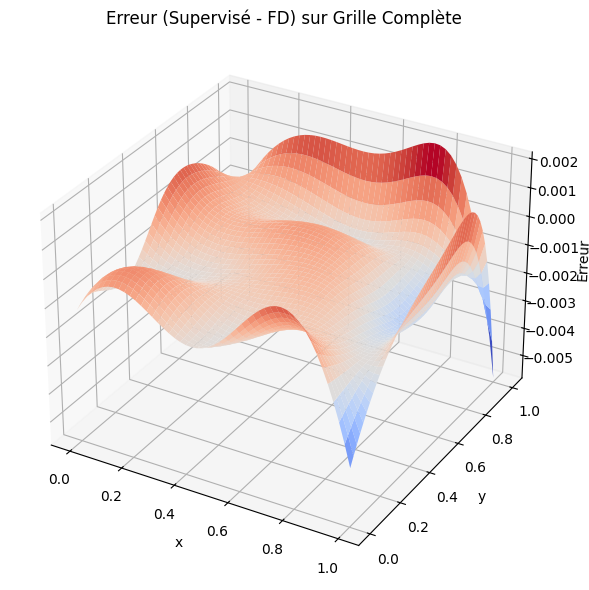

--- Supervised Model Evaluation on Test Set ---
Mean Squared Error (Supervised vs FD Test Data): 1.097328e-06
Relative L2 Error (Supervised vs FD Test Data): 0.062836

--- Comparison of Errors vs FD Reference ---
  PINN (on full grid): MSE: 1.615547e-05, Relative L2: 0.253479
  Supervised (on test set): MSE: 1.097328e-06, Relative L2: 0.062836


In [ ]:
# Calcul de l'erreur Supervisé vs FD (sur la grille complète pour visualisation)
error_sup_fd_grid = u_pred_sup - u_fd

# Visualisation de l'erreur (sur la grille complète)
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, error_sup_fd_grid, levels=50, cmap="coolwarm")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Erreur (Supervisé - FD) sur Grille Complète")
plt.show()

fig_err_sup = plt.figure(figsize=(8, 6))
ax_err_sup = fig_err_sup.add_subplot(111, projection="3d")
ax_err_sup.plot_surface(X, Y, error_sup_fd_grid, cmap="coolwarm")
ax_err_sup.set_xlabel("x")
ax_err_sup.set_ylabel("y")
ax_err_sup.set_zlabel("Erreur")
ax_err_sup.set_title("Erreur (Supervisé - FD) sur Grille Complète")
plt.tight_layout()
plt.show()

# --- Evaluation sur le Test Set ---
model_sup.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Ensure test data is on the correct device
    y_pred_test = model_sup(X_test)

# Ensure comparison happens on CPU or consistently
error_sup_test = (y_pred_test - y_test).cpu().numpy()
mse_sup_test = np.mean(error_sup_test**2)

# Calculate Relative L2 Error on the test set targets (on device)
norm_y_test = torch.linalg.norm(y_test).item()
if norm_y_test < 1e-10:
    relative_l2_error_sup_test = torch.linalg.norm(y_pred_test - y_test).item()
else:
    relative_l2_error_sup_test = (
        torch.linalg.norm(y_pred_test - y_test) / norm_y_test
    ).item()

print("--- Supervised Model Evaluation on Test Set ---")
print(f"Mean Squared Error (Supervised vs FD Test Data): {mse_sup_test:.6e}")
print(
    f"Relative L2 Error (Supervised vs FD Test Data): {relative_l2_error_sup_test:.6f}"
)

print("\n--- Comparison of Errors vs FD Reference ---")
print(
    f"  PINN (on full grid): MSE: {mse_pinn_fd:.6e}, Relative L2: {relative_l2_error_pinn_fd:.6f}"
)
print(
    f"  Supervised (on test set): MSE: {mse_sup_test:.6e}, Relative L2: {relative_l2_error_sup_test:.6f}"
)

## 2.7 Discussion: PINN vs Régression Supervisée

La **régression supervisée** apprend directement à partir des données de la solution numérique (FD). Si les données sont précises et couvrent bien le domaine, le modèle supervisé peut atteindre une très faible erreur par rapport à ces données d'entraînement (comme le montrent les métriques MSE et L2). Cependant, cette approche dépend entièrement de la disponibilité et de la qualité de la solution numérique préalable. Elle n'incorpore pas directement la physique de l'équation (comme le résidu de l'EDP) dans son processus d'apprentissage.

Le **PINN**, en revanche, apprend en minimisant le résidu de l'équation différentielle et les conditions aux limites. Il n'a pas besoin d'une solution numérique préalable pour l'entraînement (seulement pour la comparaison/validation). Le PINN incorpore la physique du problème dans sa fonction de coût. Son erreur par rapport à la solution FD peut être plus élevée que celle du modèle supervisé (qui est entraîné *sur* cette solution FD), mais il a le potentiel de découvrir des solutions même lorsque les solveurs numériques traditionnels sont coûteux ou difficiles à appliquer. L'erreur du PINN reflète à la fois sa capacité à approximer la fonction et sa capacité à satisfaire l'EDP.

En résumé :
- **Supervisé** : Bon pour reproduire des données existantes, nécessite des données de solution.
- **PINN** : Bon pour résoudre des EDPs sans données de solution (ou avec peu de données), incorpore la physique.